# **Hi to all! This is my quick start notebook.**

# Hmm, the result of this notebook on the public dataset is interesting.... 0.540 is a lot, considering the failure of the model on the validation set, we will improve the model

# version 2 and 3 - Added cross validation

# version 4 - Added LGBM from this notebook https://www.kaggle.com/code/davidjlochner/base-tfidf-lgbm

# versions 5-8 - I tried changing the ngram parameter, but ngram=(1,1) seems to work best

# version 9 - Used autogluon to build the model

# version 12 - Make custom scorer fot the autogluon - This only worsened the result

# version 14-16 - Added cross validation 

# version 17 - Used new preprocessing from this great notebook https://www.kaggle.com/code/ye11725/tfidf-lgbm-baseline-with-code-comments

# version 21 - Used new model from this great notebook https://www.kaggle.com/code/ye11725/tfidf-lgbm-baseline-with-code-comments, which works much better

# version 23 - I will try to use GaussianNB to transform the results of the regression model into class labels

# version 25 - Restored the previous version because the idea didn't work

# version 27 - The number of folds has been increased

# version 31 - add pseudo labeling: The idea did not work

# version 35 - Added new post-processing and result analysisk

# version 36 - Added CountVectorizer from https://www.kaggle.com/code/hideyukizushi/aes2-5folddeberta-lgbm-countvectorizer-lb-810

# version 44 - Partially added pipeline from here https://www.kaggle.com/code/hideyukizushi/aes2-deberta-lgbm-countvectorizer-lb-814?scriptVersionId=173181256

Choose the appropriate version of autogluon to train on GPU or CPU

In [1]:
#!pip install -q --no-index --find-links=/kaggle/input/autogluon-cpu autogluon
#!pip install -q --no-index --find-links=/kaggle/input/autogluon-gpu autogluon

In [2]:
# Importing necessary libraries
import torch
import copy
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments,DataCollatorWithPadding
import nltk
from datasets import Dataset
from glob import glob
import numpy as np 
import pandas as pd
import polars as pl
import re
import random
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import gc
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import nltk
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import random
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier,GradientBoostingClassifier,BaggingClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB,MultinomialNB,ComplementNB
from sklearn.neural_network import MLPClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.pipeline import Pipeline
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
#from autogluon.tabular.models import NNFastAiTabularModel
#from autogluon.tabular import TabularDataset, TabularPredictor
from lightgbm import log_evaluation, early_stopping
from sklearn.linear_model import SGDClassifier
import polars as pl
import pickle
from scipy.special import softmax
nltk.download('wordnet')

2024-04-23 05:30:27.376389: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-23 05:30:27.376506: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-23 05:30:27.497653: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[nltk_data] Error loading wordnet: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


False

In [3]:
MAX_LENGTH = 1024
TEST_DATA_PATH = "/kaggle/input/learning-agency-lab-automated-essay-scoring-2/test.csv"
MODEL_PATH = '/kaggle/input/aes2-400-20240419134941/*/*'
EVAL_BATCH_SIZE = 1
models = glob(MODEL_PATH)
tokenizer = AutoTokenizer.from_pretrained(models[0])

def tokenize(sample):
    return tokenizer(sample['full_text'], max_length=MAX_LENGTH, truncation=True)

df_test = pd.read_csv(TEST_DATA_PATH)
ds = Dataset.from_pandas(df_test).map(tokenize).remove_columns(['essay_id', 'full_text'])

args = TrainingArguments(
    ".", 
    per_device_eval_batch_size=EVAL_BATCH_SIZE, 
    report_to="none"
)

predictions = []
for model in models:
    model = AutoModelForSequenceClassification.from_pretrained(model)
    trainer = Trainer(
        model=model, 
        args=args, 
        data_collator=DataCollatorWithPadding(tokenizer), 
        tokenizer=tokenizer
    )    
    preds = trainer.predict(ds).predictions
    predictions.append(softmax(preds, axis=-1))
    del model, trainer
    torch.cuda.empty_cache()
    gc.collect()
    
predicted_score = 0.
for p in predictions:
    predicted_score += p
    
predicted_score /= len(predictions)
df_test['score'] = predicted_score.argmax(-1) + 1
df_test.head()
df_test[['essay_id', 'score']].to_csv('submission1.csv', index=False)

  0%|          | 0/3 [00:00<?, ?ex/s]

In [4]:
columns = [  
    (
        pl.col("full_text").str.split(by="\n\n").alias("paragraph")
    ),
]
PATH = "/kaggle/input/learning-agency-lab-automated-essay-scoring-2/"
# 载入训练集和测试集，同时对full_text数据使用\n\n字符分割为列表，重命名为paragraph
# Load training and testing sets, while using \ n \ n character segmentation to list and renaming to paragraph for full_text data
train = pl.read_csv(PATH + "train.csv").with_columns(columns)
test = pl.read_csv(PATH + "test.csv").with_columns(columns)
# 显示训练集中的第一个样本数据
# Display the first sample data in the training set
train.head(1)

essay_id,full_text,score,paragraph
str,str,i64,list[str]
"""000d118""","""Many people ha…",3,"[""Many people have car where they live. The thing they don't know is that when you use a car alot of thing can happen like you can get in accidet or the smoke that the car has is bad to breath on if someone is walk but in VAUBAN,Germany they dont have that proble because 70 percent of vauban's families do not own cars,and 57 percent sold a car to move there. Street parkig ,driveways and home garages are forbidden on the outskirts of freiburd that near the French and Swiss borders. You probaly won't see a car in Vauban's streets because they are completely ""car free"" but If some that lives in VAUBAN that owns a car ownership is allowed,but there are only two places that you can park a large garages at the edge of the development,where a car owner buys a space but it not cheap to buy one they sell the space for you car for $40,000 along with a home. The vauban people completed this in 2006 ,they said that this an example of a growing trend in Europe,The untile states and some where else are suburban life from auto use this is called ""smart planning"". The current efforts to drastically reduce greenhouse gas emissions from tailes the passengee cars are responsible for 12 percent of greenhouse gas emissions in Europe and up to 50 percent in some car intensive in the United States. I honeslty think that good idea that they did that is Vaudan because that makes cities denser and better for walking and in VAUBAN there are 5,500 residents within a rectangular square mile. In the artical David Gold berg said that ""All of our development since World war 2 has been centered on the cars,and that will have to change"" and i think that was very true what David Gold said because alot thing we need cars to do we can go anyway were with out cars beacuse some people are a very lazy to walk to place thats why they alot of people use car and i think that it was a good idea that that they did that in VAUBAN so people can see how we really don't need car to go to place from place because we can walk from were we need to go or we can ride bycles with out the use of a car. It good that they are doing that if you thik about your help the earth in way and thats a very good thing to. In the United states ,the Environmental protection Agency is promoting what is called ""car reduced""communtunties,and the legislators are starting to act,if cautiously. Maany experts expect pubic transport serving suburbs to play a much larger role in a new six years federal transportation bill to approved this year. In previous bill,80 percent of appropriations have by law gone to highways and only 20 percent to other transports. There many good reason why they should do this. ""]"


In [5]:
# Importing the ProfileReport class from the ydata_profiling library
#from ydata_profiling import ProfileReport

# Generating a profile report for the train dataset
# Setting the title of the report to "Pandas Profiling Report"
#profile = ProfileReport(train, title="Pandas Profiling Report")

# Displaying the generated profile report
#profile

**A quick analysis showed that the class distribution resembles a normal distribution, interestingly….**


**Let's try to build a simple base model so we have something to go off of.
I will use a bag-of-words model with the addition of feature selection, which can simplify the classification model.**


# **Preprocessing**

## Features engineering - https://www.kaggle.com/code/ye11725/tfidf-lgbm-baseline-with-code-comments

In [6]:
cList = {
  "ain't": "am not","aren't": "are not","can't": "cannot","can't've": "cannot have","'cause": "because",  "could've": "could have","couldn't": "could not","couldn't've": "could not have","didn't": "did not","doesn't": "does not","don't": "do not","hadn't": "had not","hadn't've": "had not have","hasn't": "has not",
  "haven't": "have not","he'd": "he would","he'd've": "he would have","he'll": "he will","he'll've": "he will have","he's": "he is",
  "how'd": "how did","how'd'y": "how do you","how'll": "how will","how's": "how is","I'd": "I would","I'd've": "I would have","I'll": "I will","I'll've": "I will have","I'm": "I am","I've": "I have",
  "isn't": "is not","it'd": "it had","it'd've": "it would have","it'll": "it will", "it'll've": "it will have","it's": "it is","let's": "let us","ma'am": "madam","mayn't": "may not",
  "might've": "might have","mightn't": "might not","mightn't've": "might not have","must've": "must have","mustn't": "must not","mustn't've": "must not have","needn't": "need not","needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not","oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
  "shan't've": "shall not have","she'd": "she would","she'd've": "she would have","she'll": "she will","she'll've": "she will have","she's": "she is",
  "should've": "should have","shouldn't": "should not","shouldn't've": "should not have","so've": "so have","so's": "so is","that'd": "that would","that'd've": "that would have","that's": "that is","there'd": "there had","there'd've": "there would have","there's": "there is","they'd": "they would","they'd've": "they would have","they'll": "they will","they'll've": "they will have","they're": "they are","they've": "they have","to've": "to have","wasn't": "was not","we'd": "we had",
  "we'd've": "we would have","we'll": "we will","we'll've": "we will have","we're": "we are","we've": "we have",
  "weren't": "were not","what'll": "what will","what'll've": "what will have",
  "what're": "what are","what's": "what is","what've": "what have","when's": "when is","when've": "when have",
  "where'd": "where did","where's": "where is","where've": "where have","who'll": "who will","who'll've": "who will have","who's": "who is","who've": "who have","why's": "why is",
  "why've": "why have","will've": "will have","won't": "will not","won't've": "will not have","would've": "would have","wouldn't": "would not",
  "wouldn't've": "would not have","y'all": "you all","y'alls": "you alls","y'all'd": "you all would",
  "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you had","you'd've": "you would have","you'll": "you you will","you'll've": "you you will have","you're": "you are",  "you've": "you have"
   }

c_re = re.compile('(%s)' % '|'.join(cList.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text)

def removeHTML(x):
    html=re.compile(r'<.*?>')
    return html.sub(r'',x)
def dataPreprocessing(x):
    x = x.lower()
    x = removeHTML(x)
    x = re.sub("@\w+", '',x)
    x = re.sub("'\d+", '',x)
    x = re.sub("\d+", '',x)
    x = re.sub("http\w+", '',x)
    x = re.sub(r"\s+", " ", x)
#     x = expandContractions(x)
    x = re.sub(r"\.+", ".", x)
    x = re.sub(r"\,+", ",", x)
    x = x.strip()
    return x

### 2.Paragraph Features

In [7]:
# 段落特征
# paragraph features
def Paragraph_Preprocess(tmp):
    # 将段落列表扩展为一行行的数据
    # Expand the paragraph list into several lines of data
    tmp = tmp.explode('paragraph')
    # 段落预处理
    # Paragraph preprocessing
    tmp = tmp.with_columns(pl.col('paragraph').map_elements(dataPreprocessing))
    # 计算每一个段落的长度
    # Calculate the length of each paragraph
    tmp = tmp.with_columns(pl.col('paragraph').map_elements(lambda x: len(x)).alias("paragraph_len"))
    # 计算每一个段落中句子的数量和单词的数量
    # Calculate the number of sentences and words in each paragraph
    tmp = tmp.with_columns(pl.col('paragraph').map_elements(lambda x: len(x.split('.'))).alias("paragraph_sentence_cnt"),
                    pl.col('paragraph').map_elements(lambda x: len(x.split(' '))).alias("paragraph_word_cnt"),)
    return tmp
# feature_eng
paragraph_fea = ['paragraph_len','paragraph_sentence_cnt','paragraph_word_cnt']
def Paragraph_Eng(train_tmp):
    aggs = [
        # 统计段落长度大于和小于 i 值的个数
        # Count the number of paragraph lengths greater than and less than the i-value
        *[pl.col('paragraph').filter(pl.col('paragraph_len') >= i).count().alias(f"paragraph_{i}_cnt") for i in [50,75,100,125,150,175,200,250,300,350,400,500,600,700] ], 
        *[pl.col('paragraph').filter(pl.col('paragraph_len') <= i).count().alias(f"paragraph_{i}_cnt") for i in [25,49]], 
        # 其他
        # other
        *[pl.col(fea).max().alias(f"{fea}_max") for fea in paragraph_fea],
        *[pl.col(fea).mean().alias(f"{fea}_mean") for fea in paragraph_fea],
        *[pl.col(fea).min().alias(f"{fea}_min") for fea in paragraph_fea],
        *[pl.col(fea).first().alias(f"{fea}_first") for fea in paragraph_fea],
        *[pl.col(fea).last().alias(f"{fea}_last") for fea in paragraph_fea],
        ]
    df = train_tmp.group_by(['essay_id'], maintain_order=True).agg(aggs).sort("essay_id")
    df = df.to_pandas()
    return df
tmp = Paragraph_Preprocess(train)
train_feats = Paragraph_Eng(tmp)
train_feats['score'] = train['score']
# 获取特征名称
# Obtain feature names
feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_feats.columns))
print('Features Number: ',len(feature_names))
train_feats.head(3)

Features Number:  31


,essay_id,paragraph_50_cnt,paragraph_75_cnt,paragraph_100_cnt,paragraph_125_cnt,paragraph_150_cnt,paragraph_175_cnt,paragraph_200_cnt,paragraph_250_cnt,paragraph_300_cnt,...,paragraph_len_min,paragraph_sentence_cnt_min,paragraph_word_cnt_min,paragraph_len_first,paragraph_sentence_cnt_first,paragraph_word_cnt_first,paragraph_len_last,paragraph_sentence_cnt_last,paragraph_word_cnt_last,score
0,000d118,1,1,1,1,1,1,1,1,1,...,2640,14,491,2640,14,491,2640,14,491,3
1,000fe60,5,5,5,5,5,5,4,3,3,...,184,3,37,184,4,37,235,3,46,3
2,001ab80,4,4,4,4,4,4,4,4,4,...,476,5,85,576,5,101,476,5,85,4


### 3.Sentence Features

In [8]:
# sentence feature
def Sentence_Preprocess(tmp):
    # 对full_text预处理，并且使用句号分割出文本的句子
    # Preprocess full_text and use periods to segment sentences in the text
    tmp = tmp.with_columns(pl.col('full_text').map_elements(dataPreprocessing).str.split(by=".").alias("sentence"))
    tmp = tmp.explode('sentence')
    # 计算句子的长度
    # Calculate the length of a sentence
    tmp = tmp.with_columns(pl.col('sentence').map_elements(lambda x: len(x)).alias("sentence_len"))
    # 筛选出句子长度大于15的那一部分数据
    # Filter out the portion of data with a sentence length greater than 15
    tmp = tmp.filter(pl.col('sentence_len')>=15)
    # 统计每一句中单词的数量
    # Count the number of words in each sentence
    tmp = tmp.with_columns(pl.col('sentence').map_elements(lambda x: len(x.split(' '))).alias("sentence_word_cnt"))
    
    return tmp
# feature_eng
sentence_fea = ['sentence_len','sentence_word_cnt']
def Sentence_Eng(train_tmp):
    aggs = [
        # 统计句子长度大于 i 的句子个数
        # Count the number of sentences with a length greater than i
        *[pl.col('sentence').filter(pl.col('sentence_len') >= i).count().alias(f"sentence_{i}_cnt") for i in [15,50,100,150,200,250,300] ], 
        # 其他
        # other
        *[pl.col(fea).max().alias(f"{fea}_max") for fea in sentence_fea],
        *[pl.col(fea).mean().alias(f"{fea}_mean") for fea in sentence_fea],
        *[pl.col(fea).min().alias(f"{fea}_min") for fea in sentence_fea],
        *[pl.col(fea).first().alias(f"{fea}_first") for fea in sentence_fea],
        *[pl.col(fea).last().alias(f"{fea}_last") for fea in sentence_fea],
        ]
    df = train_tmp.group_by(['essay_id'], maintain_order=True).agg(aggs).sort("essay_id")
    df = df.to_pandas()
    return df

tmp = Sentence_Preprocess(train)
# 将新生成的特征数据和之前生成的特征数据合并
# Merge the newly generated feature data with the previously generated feature data
train_feats = train_feats.merge(Sentence_Eng(tmp), on='essay_id', how='left')

feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_feats.columns))
print('Features Number: ',len(feature_names))
train_feats.head(3)

Features Number:  48


,essay_id,paragraph_50_cnt,paragraph_75_cnt,paragraph_100_cnt,paragraph_125_cnt,paragraph_150_cnt,paragraph_175_cnt,paragraph_200_cnt,paragraph_250_cnt,paragraph_300_cnt,...,sentence_len_max,sentence_word_cnt_max,sentence_len_mean,sentence_word_cnt_mean,sentence_len_min,sentence_word_cnt_min,sentence_len_first,sentence_word_cnt_first,sentence_len_last,sentence_word_cnt_last
0,000d118,1,1,1,1,1,1,1,1,1,...,593,127,202.076923,38.692308,36,7,36,7,47,10
1,000fe60,5,5,5,5,5,5,4,3,3,...,250,49,96.823529,20.470588,27,7,62,13,124,25
2,001ab80,4,4,4,4,4,4,4,4,4,...,237,47,126.708333,23.875000,58,10,144,27,58,10


### 4.Word Features

In [9]:
# word feature
def Word_Preprocess(tmp):
    # 对full_text预处理，并且使用空格符分割出文本的单词
    # Preprocess full_text and use spaces to separate words from the text
    tmp = tmp.with_columns(pl.col('full_text').map_elements(dataPreprocessing).str.split(by=" ").alias("word"))
    tmp = tmp.explode('word')
    # 计算每一个的单词长度
    # Calculate the length of each word
    tmp = tmp.with_columns(pl.col('word').map_elements(lambda x: len(x)).alias("word_len"))
    # 删除单词长度为0的数据
    # Delete data with a word length of 0
    tmp = tmp.filter(pl.col('word_len')!=0)
    
    return tmp
# feature_eng
def Word_Eng(train_tmp):
    aggs = [
        # 统计单词长度大于 i+1 的单词个数
        # Count the number of words with a length greater than i+1
        *[pl.col('word').filter(pl.col('word_len') >= i+1).count().alias(f"word_{i+1}_cnt") for i in range(15) ], 
        # 其他
        # other
        pl.col('word_len').max().alias(f"word_len_max"),
        pl.col('word_len').mean().alias(f"word_len_mean"),
        pl.col('word_len').std().alias(f"word_len_std"),
        pl.col('word_len').quantile(0.25).alias(f"word_len_q1"),
        pl.col('word_len').quantile(0.50).alias(f"word_len_q2"),
        pl.col('word_len').quantile(0.75).alias(f"word_len_q3"),
        ]
    df = train_tmp.group_by(['essay_id'], maintain_order=True).agg(aggs).sort("essay_id")
    df = df.to_pandas()
    return df

tmp = Word_Preprocess(train)
# 将新生成的特征数据和之前生成的特征数据合并
# Merge the newly generated feature data with the previously generated feature data
train_feats = train_feats.merge(Word_Eng(tmp), on='essay_id', how='left')

feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_feats.columns))
print('Features Number: ',len(feature_names))
train_feats.head(3)

Features Number:  69


,essay_id,paragraph_50_cnt,paragraph_75_cnt,paragraph_100_cnt,paragraph_125_cnt,paragraph_150_cnt,paragraph_175_cnt,paragraph_200_cnt,paragraph_250_cnt,paragraph_300_cnt,...,word_12_cnt,word_13_cnt,word_14_cnt,word_15_cnt,word_len_max,word_len_mean,word_len_std,word_len_q1,word_len_q2,word_len_q3
0,000d118,1,1,1,1,1,1,1,1,1,...,6,6,5,2,25,4.378819,2.538495,3.0,4.0,5.0
1,000fe60,5,5,5,5,5,5,4,3,3,...,0,0,0,0,11,4.012048,2.060968,2.0,4.0,5.0
2,001ab80,4,4,4,4,4,4,4,4,4,...,14,10,5,2,15,4.574545,2.604621,3.0,4.0,5.0


### 5.Tf-idf features

In [10]:
# TfidfVectorizer parameter
vectorizer = TfidfVectorizer(
            tokenizer=lambda x: x,
            preprocessor=lambda x: x,
            token_pattern=None,
            strip_accents='unicode',
            analyzer = 'word',
            ngram_range=(4,8),
            min_df=0.05,
            max_df=0.95,
            sublinear_tf=True,
)
# 将全部数据集都填充进TfidfVectorizer里，这可能会造成泄露和过于乐观的CV分数
# Fit all datasets into TfidfVector,this may cause leakage and overly optimistic CV scores
train_tfid = vectorizer.fit_transform([i for i in train['full_text']])
# 转换为数组
# Convert to array
dense_matrix = train_tfid.toarray()
# 转换为dataframe
# Convert to dataframe
df = pd.DataFrame(dense_matrix)
# 重命名特征
# rename features
tfid_columns = [ f'tfid_{i}' for i in range(len(df.columns))]
df.columns = tfid_columns
df['essay_id'] = train_feats['essay_id']
# 将新生成的特征数据和之前生成的特征数据合并
# Merge the newly generated feature data with the previously generated feature data
train_feats = train_feats.merge(df, on='essay_id', how='left')

feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_feats.columns))
print('Features Number: ',len(feature_names))
train_feats.head(3)

Features Number:  24394


,essay_id,paragraph_50_cnt,paragraph_75_cnt,paragraph_100_cnt,paragraph_125_cnt,paragraph_150_cnt,paragraph_175_cnt,paragraph_200_cnt,paragraph_250_cnt,paragraph_300_cnt,...,tfid_24315,tfid_24316,tfid_24317,tfid_24318,tfid_24319,tfid_24320,tfid_24321,tfid_24322,tfid_24323,tfid_24324
0,000d118,1,1,1,1,1,1,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,000fe60,5,5,5,5,5,5,4,3,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,001ab80,4,4,4,4,4,4,4,4,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 6.CountVectorizer

In [11]:
vectorizer_cnt = CountVectorizer(
            tokenizer=lambda x: x,
            preprocessor=lambda x: x,
            token_pattern=None,
            strip_accents='unicode',
            analyzer = 'word',
            ngram_range=(3,5),
            min_df=0.10,
            max_df=0.85,
)
train_tfid = vectorizer_cnt.fit_transform([i for i in train['full_text']])
dense_matrix = train_tfid.toarray()
df = pd.DataFrame(dense_matrix)
tfid_columns = [ f'tfid_cnt_{i}' for i in range(len(df.columns))]
df.columns = tfid_columns
df['essay_id'] = train_feats['essay_id']
train_feats = train_feats.merge(df, on='essay_id', how='left')

feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_feats.columns))
print('Features Number: ',len(feature_names))
train_feats.head(3)

Features Number:  31753


,essay_id,paragraph_50_cnt,paragraph_75_cnt,paragraph_100_cnt,paragraph_125_cnt,paragraph_150_cnt,paragraph_175_cnt,paragraph_200_cnt,paragraph_250_cnt,paragraph_300_cnt,...,tfid_cnt_7349,tfid_cnt_7350,tfid_cnt_7351,tfid_cnt_7352,tfid_cnt_7353,tfid_cnt_7354,tfid_cnt_7355,tfid_cnt_7356,tfid_cnt_7357,tfid_cnt_7358
0,000d118,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,000fe60,5,5,5,5,5,5,4,3,3,...,0,0,0,0,0,1,1,1,0,0
2,001ab80,4,4,4,4,4,4,4,4,4,...,0,0,2,2,2,0,0,0,0,0


### 7. Meta Features(deberta-v3-large)

In [12]:
import joblib

deberta_oof = joblib.load('/kaggle/input/aes2-400-20240419134941/oof.pkl')
print(deberta_oof.shape, train_feats.shape)

for i in range(6):
    train_feats[f'deberta_oof_{i}'] = deberta_oof[:, i]

feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_feats.columns))
print('Features Number: ',len(feature_names))    

train_feats.shape

(17307, 6) (17307, 31755)
Features Number:  31759


(17307, 31761)

# **Model training**

In [13]:
# idea from https://www.kaggle.com/code/rsakata/optimize-qwk-by-lgb/notebook#QWK-objective
def quadratic_weighted_kappa(y_true, y_pred):
    y_true = y_true + a
    y_pred = (y_pred + a).clip(1, 6).round()
    qwk = cohen_kappa_score(y_true, y_pred, weights="quadratic")
    return 'QWK', qwk, True
def qwk_obj(y_true, y_pred):
    labels = y_true + a
    preds = y_pred + a
    preds = preds.clip(1, 6)
    f = 1/2*np.sum((preds-labels)**2)
    g = 1/2*np.sum((preds-a)**2+b)
    df = preds - labels
    dg = preds - a
    grad = (df/g - f*dg/g**2)*len(labels)
    hess = np.ones(len(labels))
    return grad, hess
a = 2.948
b = 1.092


In [14]:
# Converting the 'text' column to string type and assigning to X
X = train_feats[feature_names].astype(np.float32).values

# Converting the 'score' column to integer type and assigning to y
y_split = train_feats['score'].astype(int).values
y = train_feats['score'].astype(np.float32).values-a
oof = train_feats['score'].astype(np.float32).values


# **Let's use cross-validation**

In [15]:
if_train=False # You can train your model here, I'm currently using the models trained in version 47 of this notebook


In [16]:

if if_train:
    # Define the number of splits for cross-validation
    n_splits = 15

    # Initialize StratifiedKFold with the specified number of splits
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

    # Lists to store scores
    f1_scores = []
    kappa_scores = []
    models = []
    predictions = []
    callbacks = [log_evaluation(period=25), early_stopping(stopping_rounds=75,first_metric_only=True)]
    # Loop through each fold of the cross-validation
    i=1
    for train_index, test_index in skf.split(X, y_split):
        # Split the data into training and testing sets for this fold
        print('fold',i)
        X_train_fold, X_test_fold = X[train_index], X[test_index]


        y_train_fold, y_test_fold, y_test_fold_int = y[train_index], y[test_index], y_split[test_index]



        model = lgb.LGBMRegressor(
                    objective = qwk_obj,
                    metrics = 'None',
                    learning_rate = 0.1,
                    max_depth = 5,
                    num_leaves = 10,
                    colsample_bytree=0.5,
                    reg_alpha = 0.1,
                    reg_lambda = 0.8,
                    n_estimators=1024,
                    random_state=42,
                    extra_trees=True,
                    class_weight='balanced',

                    verbosity = - 1)

        # Fit the model on the training data for this fold

        predictor = model.fit(X_train_fold,
                                      y_train_fold,
                                      eval_names=['train', 'valid'],
                                      eval_set=[(X_train_fold, y_train_fold), (X_test_fold, y_test_fold)],
                                      eval_metric=quadratic_weighted_kappa,
                                      callbacks=callbacks,)
        models.append(predictor)
        # Make predictions on the test data for this fold
        predictions_fold = predictor.predict(X_test_fold)
        predictions_fold = predictions_fold + a
        predictions_fold = predictions_fold.clip(1, 6).round()
        predictions.append(predictions_fold)
        # Calculate and store the F1 score for this fold
        f1_fold = f1_score(y_test_fold_int, predictions_fold, average='weighted')
        f1_scores.append(f1_fold)

        # Calculate and store the Cohen's kappa score for this fold
        kappa_fold = cohen_kappa_score(y_test_fold_int, predictions_fold, weights='quadratic')
        kappa_scores.append(kappa_fold)

        # Calculating the confusion matrix
        cm = confusion_matrix(y_test_fold_int, predictions_fold, labels=[x for x in range(1,7)])

        # Displaying the confusion matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                      display_labels=[x for x in range(1,7)])
        disp.plot()
        plt.show()
        print(f'F1 score across fold: {f1_fold}')
        print(f'Cohen kappa score across fold: {kappa_fold}')
        i+=1
    # Calculate the mean scores across all folds
    mean_f1_score = np.mean(f1_scores)
    mean_kappa_score = np.mean(kappa_scores)

    # Print the mean scores
    print(f'Mean F1 score across {n_splits} folds: {mean_f1_score}')
    print(f'Mean Cohen kappa score across {n_splits} folds: {mean_kappa_score}')

    # Зберегти список моделей у файл
    with open('models.pkl', 'wb') as f:
        pickle.dump(models, f)
else:
    with open('/kaggle/input/quick-start-lgbm-version-30/models.pkl', 'rb') as f:
        models = pickle.load(f)
    

In [17]:

# Define the number of splits for cross-validation
n_splits = 15

# Initialize StratifiedKFold with the specified number of splits
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
oof=oof.astype('float32')

# Loop through each fold of the cross-validation
i=0
for train_index, test_index in skf.split(X, y_split):
    # Split the data into training and testing sets for this fold
    print('fold',i)
    X_train_fold, X_test_fold = X[train_index], X[test_index]


    y_train_fold, y_test_fold, y_test_fold_int = y[train_index], y[test_index], y_split[test_index]



    predictor = models[i]
    # Make predictions on the test data for this fold
    predictions_fold = predictor.predict(X_test_fold)
    predictions_fold = predictions_fold + a
    oof[test_index]=predictions_fold
    #predictions_fold = predictions_fold.clip(1, 6).round()
    
    i+=1
oof

fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
fold 11
fold 12
fold 13
fold 14


array([1.7276548, 2.9004388, 4.555749 , ..., 1.873485 , 1.3585144,
       1.4385991], dtype=float32)

# Displaying the results of model predictions

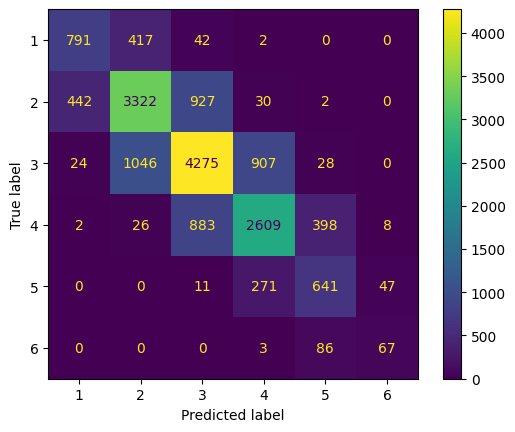

Mean F1 score across 15 folds: 0.6765139416275214
Mean Cohen kappa score across 15 folds: 0.8387646949265729


In [18]:
 # Calculate and store the F1 score for this fold
mean_f1_score = f1_score(y_split, oof.clip(1, 6).round(), average='weighted')

# Calculate and store the Cohen's kappa score for this fold
mean_kappa_score = cohen_kappa_score(y_split, oof.clip(1, 6).round(), weights='quadratic')

# Calculating the confusion matrix
cm = confusion_matrix(y_split, oof.clip(1, 6).round(), labels=[x for x in range(1,7)])

# Displaying the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[x for x in range(1,7)])
disp.plot()
plt.show()
# Print the mean scores
print(f'Mean F1 score across {n_splits} folds: {mean_f1_score}')
print(f'Mean Cohen kappa score across {n_splits} folds: {mean_kappa_score}')

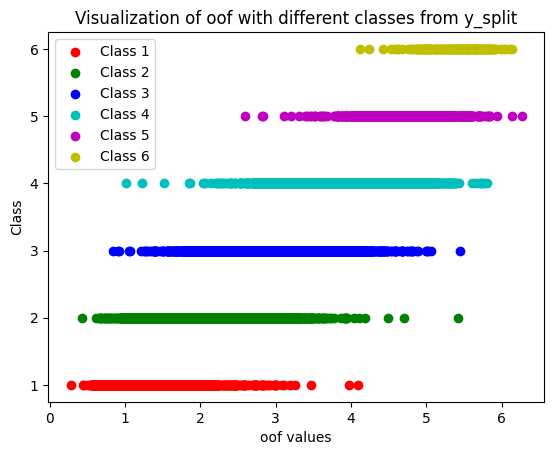

In [19]:
import matplotlib.pyplot as plt

# Припустимо, що oof та y_split - це ваші масиви

# Створюємо кольорову палітру для різних класів
colors = ['r', 'g', 'b', 'c', 'm', 'y']

# Отримуємо унікальні класи з y_split
unique_classes = set(y_split)

# Створюємо підграфік для візуалізації
plt.figure()

# Проходимося по кожному класу і відображаємо відповідні точки з oof
for cls in unique_classes:
    # Відфільтруємо точки з oof, які відповідають поточному класу
    points = oof[y_split == cls]
    # Відображаємо точки для поточного класу з відповідним кольором
    plt.scatter(points, [cls] * len(points), color=colors[cls-1], label=f'Class {cls}')

# Налаштуємо заголовок та мітки осей
plt.title('Visualization of oof with different classes from y_split')
plt.xlabel('oof values')
plt.ylabel('Class')

# Додаємо легенду
plt.legend()

# Показуємо графік
plt.show()

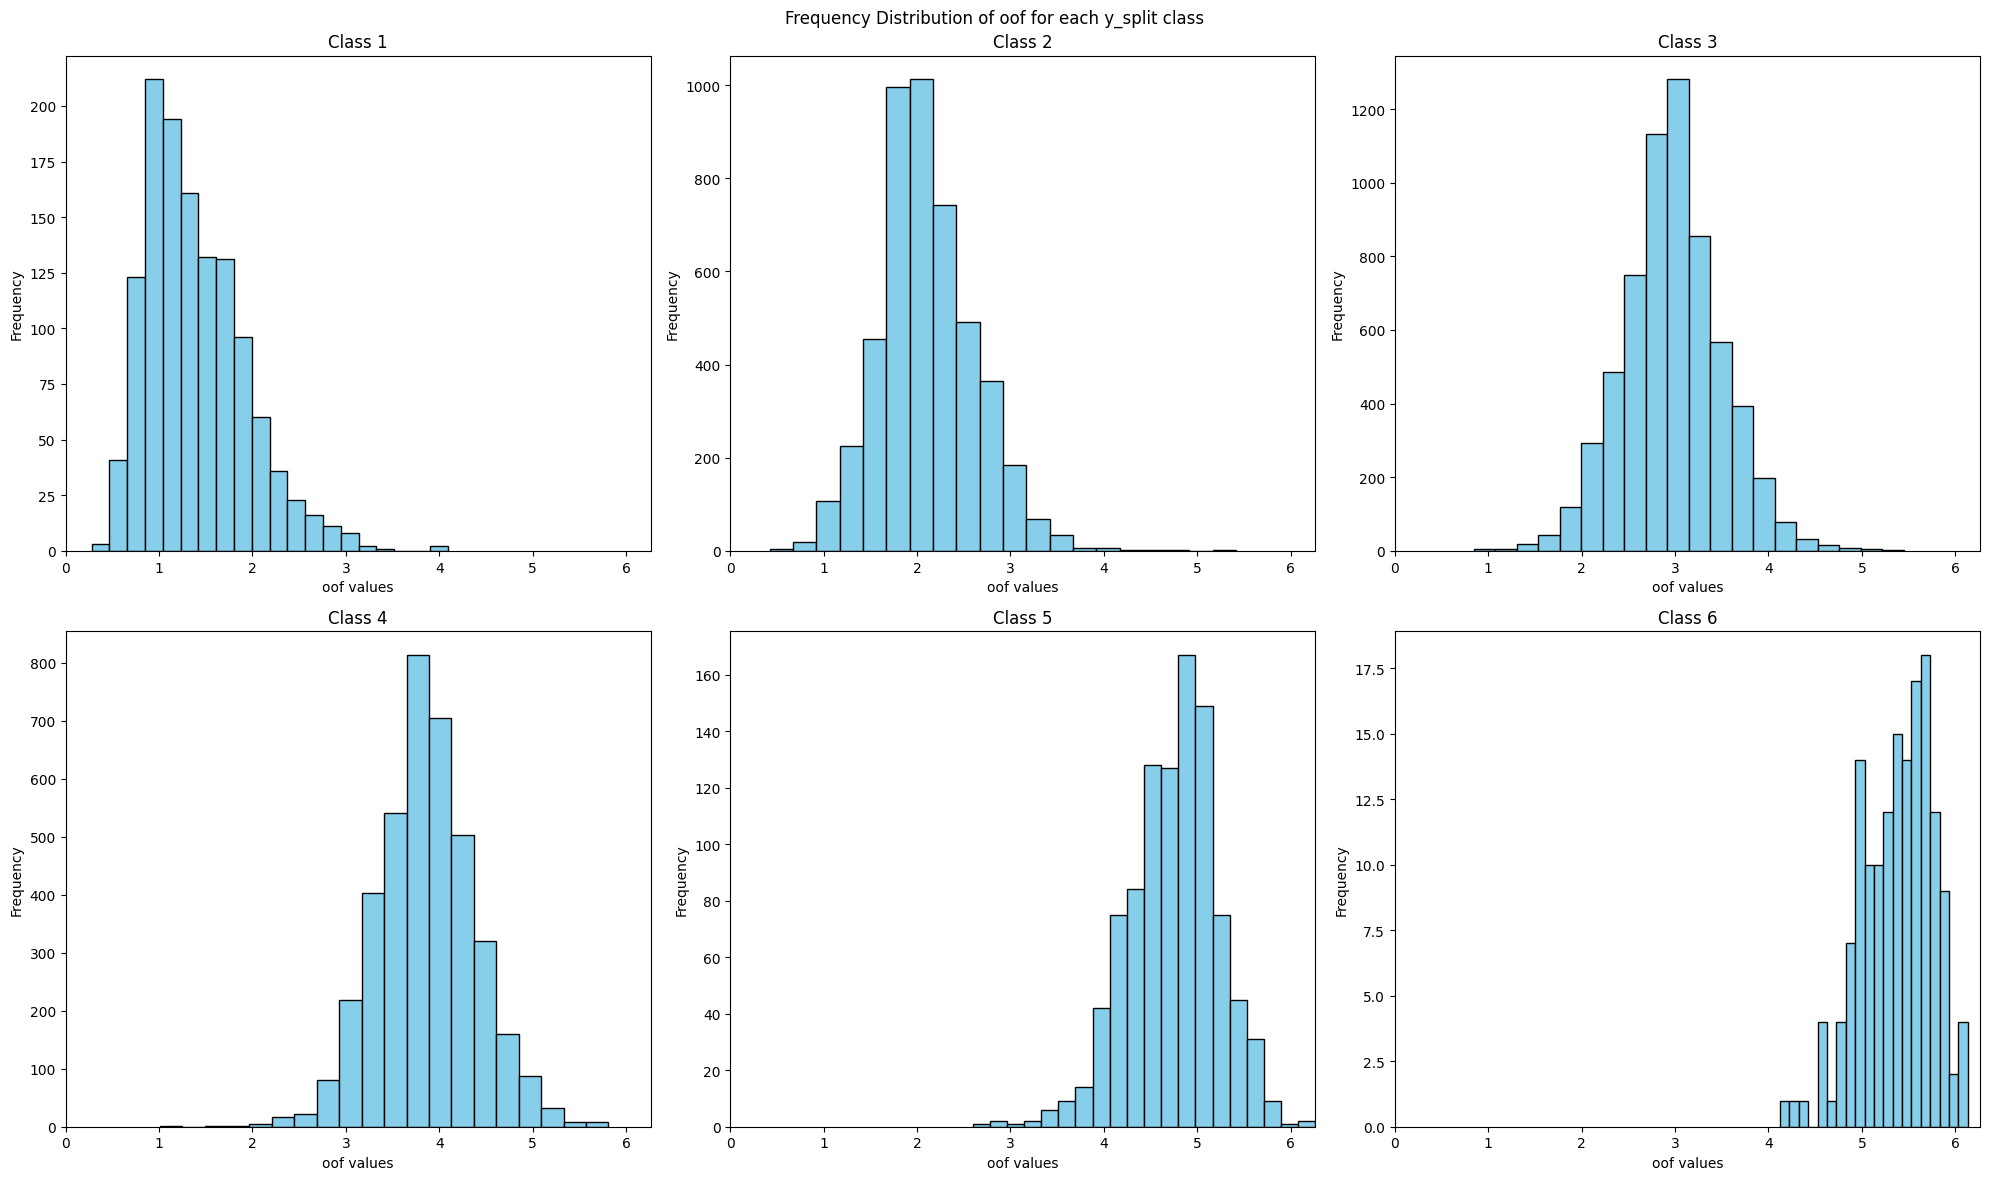

In [20]:
import matplotlib.pyplot as plt

# Припустимо, що oof та y_split - це ваші масиви

# Отримуємо унікальні класи з y_split
unique_classes = sorted(set(y_split))

# Знайдемо максимальне значення для побудови однакової сітки
max_value = max([max(oof[y_split == cls]) for cls in unique_classes])

# Створюємо новий графік для візуалізації
plt.figure(figsize=(20, 12))

# Проходимося по кожному класу і будуємо частотний графік для відповідних точок oof
for idx, cls in enumerate(unique_classes):
    # Відфільтруємо точки з oof, які відповідають поточному класу
    points = oof[y_split == cls]
    # Побудова частотного графіка для поточного класу
    plt.subplot(2, 3, idx+1)  # Побудова у вигляді 2x3 підграфіків
    plt.hist(points, color='skyblue', edgecolor='black', bins=20)
    plt.title(f'Class {cls}')
    plt.xlabel('oof values')
    plt.ylabel('Frequency')
    plt.xlim(0, max_value)  # Встановлення однакового діапазону для осі x
    plt.ylim(0, None)  # Встановлення діапазону для осі y (від 0 до максимума)

# Налаштуємо заголовок та підзаголовки
plt.suptitle('Frequency Distribution of oof for each y_split class')
plt.tight_layout()

# Показуємо графік
plt.show()


# Let's try to build a classification with thresholds

In [21]:
import numpy as np

# Оптимальні пороги для переходу між класами
optimal_thresholds = [1.5, 2.5, 3.5, 4.5, 5.5]
oof_clip = oof.clip(1, 6)
def classify_with_thresholds(oof_clip, optimal_thresholds):

    # Класифікуємо значення oof за допомогою оптимальних порогів
    classified_oof = np.empty_like(oof_clip)
    for i, threshold in enumerate(optimal_thresholds):
        if i == 0:
            classified_oof[oof_clip < threshold] = 1

        else:
            classified_oof[(oof_clip >= optimal_thresholds[i-1]) & (oof_clip < threshold)] = i + 1

        if i == 4:
            classified_oof[oof_clip >= threshold] = 6
            
    return classified_oof.astype(int)
            
classified_oof =classify_with_thresholds(oof_clip, optimal_thresholds)
    
print("Classified oof:")
print(classified_oof)

Classified oof:
[2 3 5 ... 2 1 1]


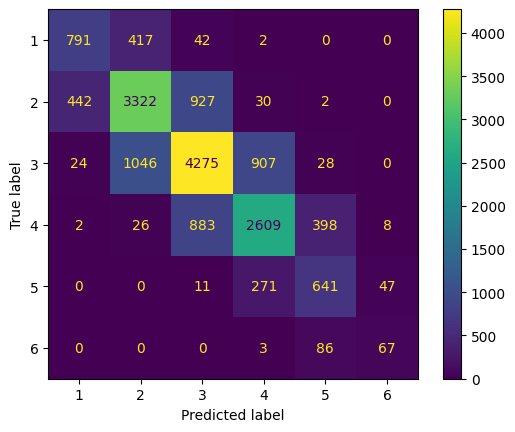

Mean F1 score across 15 folds: 0.6765139416275214
Mean Cohen kappa score across 15 folds: 0.8387646949265729


In [22]:
 # Calculate and store the F1 score for this fold
mean_f1_score = f1_score(y_split, classified_oof, average='weighted')

# Calculate and store the Cohen's kappa score for this fold
mean_kappa_score = cohen_kappa_score(y_split, classified_oof, weights='quadratic')

# Calculating the confusion matrix
cm = confusion_matrix(y_split, classified_oof, labels=[x for x in range(1,7)])

# Displaying the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[x for x in range(1,7)])
disp.plot()
plt.show()
# Print the mean scores
print(f'Mean F1 score across {n_splits} folds: {mean_f1_score}')
print(f'Mean Cohen kappa score across {n_splits} folds: {mean_kappa_score}')

In [23]:
optimal_thresholds = [1.5, 2.5, 3.5, 4.5, 5.5]
best_kappa_score=mean_kappa_score
for i in range(5):
    i_threshold=optimal_thresholds[i]-0.5
    for j in range(1000):
        thresholds=[x for x in optimal_thresholds]
        thresholds[i]=i_threshold+j/1000
        
        classified_oof =classify_with_thresholds(oof_clip, thresholds)
        threshold_kappa_score=cohen_kappa_score(y_split, classified_oof, weights='quadratic')
        #print(i,thresholds,threshold_kappa_score)
        if threshold_kappa_score>=best_kappa_score:
            best_kappa_score=threshold_kappa_score
            optimal_thresholds[i]=thresholds[i]
optimal_thresholds

[1.4969999999999999, 2.495, 3.5, 4.501, 5.382]

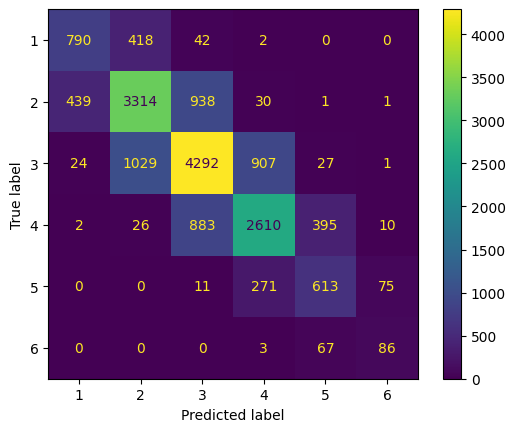

Mean F1 score across 15 folds: 0.6767195098885654
Mean Cohen kappa score across 15 folds: 0.8392208838131302


In [24]:
classified_oof =classify_with_thresholds(oof_clip, optimal_thresholds)
 # Calculate and store the F1 score for this fold
mean_f1_score = f1_score(y_split, classified_oof, average='weighted')

# Calculate and store the Cohen's kappa score for this fold
mean_kappa_score = cohen_kappa_score(y_split, classified_oof, weights='quadratic')

# Calculating the confusion matrix
cm = confusion_matrix(y_split, classified_oof, labels=[x for x in range(1,7)])

# Displaying the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[x for x in range(1,7)])
disp.plot()
plt.show()
# Print the mean scores
print(f'Mean F1 score across {n_splits} folds: {mean_f1_score}')
print(f'Mean Cohen kappa score across {n_splits} folds: {mean_kappa_score}')

# **Inference**

In [25]:
# Paragraph
tmp = Paragraph_Preprocess(test)
test_feats = Paragraph_Eng(tmp)
# Sentence
tmp = Sentence_Preprocess(test)
test_feats = test_feats.merge(Sentence_Eng(tmp), on='essay_id', how='left')
# Word
tmp = Word_Preprocess(test)
test_feats = test_feats.merge(Word_Eng(tmp), on='essay_id', how='left')

# Tfidf
test_tfid = vectorizer.transform([i for i in test['full_text']])
dense_matrix = test_tfid.toarray()
df = pd.DataFrame(dense_matrix)
tfid_columns = [ f'tfid_{i}' for i in range(len(df.columns))]
df.columns = tfid_columns
df['essay_id'] = test_feats['essay_id']
test_feats = test_feats.merge(df, on='essay_id', how='left')

# CountVectorizer
test_tfid = vectorizer_cnt.transform([i for i in test['full_text']])
dense_matrix = test_tfid.toarray()
df = pd.DataFrame(dense_matrix)
tfid_columns = [ f'tfid_cnt_{i}' for i in range(len(df.columns))]
df.columns = tfid_columns
df['essay_id'] = test_feats['essay_id']
test_feats = test_feats.merge(df, on='essay_id', how='left')

# Meta Features(deberta-v3-large)
for i in range(6):
    test_feats[f'deberta_oof_{i}'] = predicted_score[:, i]

# Features number
feature_names = list(filter(lambda x: x not in ['essay_id','score'], test_feats.columns))
print('Features number: ',len(feature_names))
test_feats.head(3)

Features number:  31759


,essay_id,paragraph_50_cnt,paragraph_75_cnt,paragraph_100_cnt,paragraph_125_cnt,paragraph_150_cnt,paragraph_175_cnt,paragraph_200_cnt,paragraph_250_cnt,paragraph_300_cnt,...,tfid_cnt_7355,tfid_cnt_7356,tfid_cnt_7357,tfid_cnt_7358,deberta_oof_0,deberta_oof_1,deberta_oof_2,deberta_oof_3,deberta_oof_4,deberta_oof_5
0,000d118,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0.005867,0.274048,0.693365,0.026059,0.000465,0.000196
1,000fe60,5,5,5,5,5,5,4,3,3,...,1,1,0,0,0.000463,0.034625,0.911631,0.052944,0.000277,0.000060
2,001ab80,4,4,4,4,4,4,4,4,4,...,0,0,0,0,0.000969,0.001600,0.018889,0.454450,0.515864,0.008228


In [26]:
probabilities = []
for model in models:
    proba= model.predict(test_feats[feature_names])+ a
    probabilities.append(proba)
# Compute the average probabilities across all models
predictions = np.mean(probabilities, axis=0)

#predictions = predictions.clip(1, 6)


predictions = np.round(predictions.clip(1, 6))
#predictions =classify_with_thresholds(predictions, optimal_thresholds)
# Print the predictions
print(predictions)


[2. 3. 4.]


In [27]:
#test_vector=new_pipeline.transform(test['text'])
#predictions=lgb_model.predict(test_vector)
#predictions

In [28]:
#predictions = model.predict(test['text'])
#predictions
# Initialize an empty list to store probabilities for each model
"""
probabilities = []

# Iterate over each model in the list of models
for model in models:
    # Make predictions using the current model
    print(model.predict(test['text']))
    
    # Compute decision scores for the current model
    decision_scores = model.decision_function(test['text'])
    
    # Convert decision scores to probabilities using the sigmoid function
    proba = 1 / (1 + np.exp(-decision_scores))
    # Append the probabilities to the list
    probabilities.append(proba)

# Compute the average probabilities across all models
probabilities = np.mean(probabilities, axis=0)

# Determine the predicted class by selecting the class with the highest probability
# Add 1 to the index to match the class labels (assuming classes start from 1)
predictions = np.argmax(probabilities, axis=1) + 1

# Print the predictions
print(predictions)
"""

"\nprobabilities = []\n\n# Iterate over each model in the list of models\nfor model in models:\n    # Make predictions using the current model\n    print(model.predict(test['text']))\n    \n    # Compute decision scores for the current model\n    decision_scores = model.decision_function(test['text'])\n    \n    # Convert decision scores to probabilities using the sigmoid function\n    proba = 1 / (1 + np.exp(-decision_scores))\n    # Append the probabilities to the list\n    probabilities.append(proba)\n\n# Compute the average probabilities across all models\nprobabilities = np.mean(probabilities, axis=0)\n\n# Determine the predicted class by selecting the class with the highest probability\n# Add 1 to the index to match the class labels (assuming classes start from 1)\npredictions = np.argmax(probabilities, axis=1) + 1\n\n# Print the predictions\nprint(predictions)\n"

In [29]:
submission=pd.read_csv("/kaggle/input/learning-agency-lab-automated-essay-scoring-2/sample_submission.csv")
submission['score']=predictions
submission['score']=submission['score'].astype(int)
submission.to_csv("submission.csv",index=None)
display(submission.head())

,essay_id,score
0,000d118,2
1,000fe60,3
2,001ab80,4
